In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# Домашнее задание 1

ДЕДЛАЙН: 25 февраля 2021, 23:59
Присылать на maxkaledin@gmail.com с темой  "Численные методы ДЗ 1 Илья Иванов"



В этой работе мы проведём ещё одно экспериментальное исследование методов интерполяции.

## Кубические сплайны

Сплайны -- один из самых используемых на практике базисов интерполяции, который отличает устойчивость к шумам и простота вычислений. Пусть $In_A( x)=1$, если $x \in A$, и $0$ иначе. В общем случае сплайном степени $n$ дефекта $k$ называют кусочно заданную функцию 
$$
S(x) = \sum_{j=0}^K S_j(x) In(x \in I_j),
$$
определённую для $x \in [a,b]$, где $S_j$ являются многочленами степени $n$, объединение отрезков $I_j$, среди которых пересекаются только соседние и в одной точке, равно $[a,b]$ и выполнены условия 

1. Непрерывности $S(x)$ на стыках интервалов: если $I_j=[t_0,t_1],~I_{j+1}=[t_1,t_2]$, то $S_j(t_1)=S_{j+1}(t_1);$
2. Непрерывности производной на стыках интервалов: для всех натуральных $k_0 \leq n-k ~~~ S_j^{(k_0)}(t_1)=S_{j+1}^{(k_0)}(t_1).$


Нам требуется найти сплайн, интерполирующий функцию $f(x)$ между узлами интерполяции $t_j$ на отрезке $[a,b]$; из определения очевидно, что вопрос существования интерполирующего сплайна с заданными степенью и дефектом не такой очевидный. В этом курсе мы рассматриваем для простоты кубический сплайн дефекта 1, который используется на практике чаще всех остальных и единственен для любого набора узлов интерполяции. Для построения такого сплайна существует простая процедура(см. лекции), основанная на методе прогонке и имеющая сложность $O(N)$. Для единственности сплайна необходимо задать граничные условия, используйте $S''(b)=S''(a)=0$, но в коде предполагайте, что пользователь сам задаёт $S''(a)$ и $S''(b)$ в качестве входных параметров.

### Задание 1 (50 баллов)

Реализуйте процедуру для интерполяции кубическим сплайном, взяв за основу код, приведённый ниже. Коэффициенты ищите с помощью метода прогонки, который позволяет решить задачу за $O(N)$. Наивный метод составления системы линейных уравнений для условий $1$ и $2$ оказывается гораздо более трудозатратным.

In [2]:
class CubicSplineInterpolator:
    
    def __init__(self,xGrid,fGrid,sppa=0,sppb=0):
        #Computes spline coefficients
        #xGrid float64 [N]
        #fGrid float64 [N]
        #sppa float64  -- boundary condition(left)
        #sppb float64  -- boundary condition(right)

        self.sppa=sppa
        self.sppb=sppb
        self.xGrid = xGrid #you will need it
        self.coeffs = self.ComputeCoefficients(xGrid,fGrid)

        #I would recommended to use list(or numpy array [N-1,3]) for coefficients
    
    def tdma(self, a, b, c, f):
        n = len(f)
        # calculate alpha, beta (forward pass)
        alpha = [-c[0] / b[0]]
        beta = [f[0] / b[0]]
        for i in range(1,n):
            alpha.append(-c[i]/(a[i]*alpha[i-1] + b[i]))
            beta.append((f[i] - a[i]*beta[i-1])/(a[i]*alpha[i-1]+b[i]))

        # calculate x (backward pass)
        x = np.zeros(n)
        x[n-1] = beta[n-1]

        for i in range(n-2, -1, -1):
            x[i] = alpha[i] * x[i+1] + beta[i]

        return x

    def ComputeCoefficients(self,xGrid,fGrid):
        #returns coefficients for cubic spline based on interpolation Grid
        #input
        #    xGrid float64 [N]
        #    fGrid float64 [N]
        #output
        #    coeffs
        
        #Your code here
        
        taus = xGrid[1:] - xGrid[:-1]
        n = len(taus)    # n + 1 points, n intervals
        
        # calculate tridiagonal system of equations using tdma
        a = np.concatenate((np.zeros(1), taus[1:n-1] / 6))
        b = (taus[:n-1] + taus[1:]) / 3
        c = np.concatenate((taus[1:n-1] / 6, np.zeros(1)))
        f = (fGrid[2:] - fGrid[1:n]) / taus[1:] - (fGrid[1:n] - fGrid[:n-1]) / taus[:n-1]
        m_coefs = self.tdma(a, b, c, f)    # m_1, ..., m_{n-1}
        m_coefs = np.concatenate((np.array([self.sppa]), m_coefs, np.array([self.sppb])))    # m_0,...,m_n
        a_coefs = (fGrid[1:] - fGrid[:n]) / taus - (m_coefs[1:] - m_coefs[:n]) * taus / 6
        b_coefs = fGrid[:n] - m_coefs[:n] * (taus ** 2) / 6 - a_coefs * xGrid[:n]
        self.coefs = (m_coefs, a_coefs, b_coefs)
        return self.coefs
        
    def Compute(self,x):
        #computes spline value at point x
        #input
        #    x float64 [batch]
        #output
        #    S(x) float64 [batch]
        
        #Your code here
        #1.Check to which interval x belongs
        #2.Use corresponding coefficients from self.coeffs to compute S(x)
        n = len(self.xGrid) - 1
        m, a, b = self.coefs
        taus = self.xGrid[1:] - self.xGrid[:-1]
        intervals_idx = np.searchsorted(self.xGrid, x, side='right') - 1
        intervals_idx[intervals_idx == n] -= 1    # n + 1 to n
        return 1 / (6 * taus[intervals_idx]) * (m[intervals_idx] * (self.xGrid[intervals_idx + 1] - x)**3 + \
                                                m[intervals_idx + 1] * (x - self.xGrid[intervals_idx])**3) + \
                                                a[intervals_idx] * x + b[intervals_idx]

Проверьте, как работает интерполяция для функции $f(x)$ без шума и в случае $\tilde{f}(x) = f(x) + \sigma \mathcal{N}(0,1)$. Нарисуйте графики $S(x),f(x)$ и узлы интерполяции (используйте scatter). Попробуйте несколько разных $\sigma$.

Сравните результат с интерполяцией многочленами Ньютона (см. семинары).

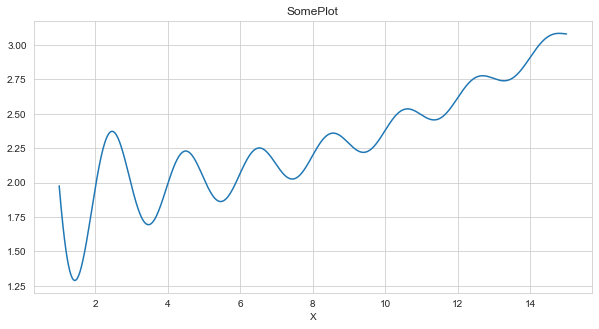

In [3]:
def fTest(x):
    #maps R -> R
    #input x [batch]
    #output [batch]
    
    return np.exp(-0.1*x) + 1/x * np.sin(1*np.pi * x)+ np.exp(0.07*x)

x0=1
x1=15
N= 2000#number of knots
h= (x1-x0)/(N-1)
xs = np.arange(x0,x1+h/2,h)


f,ax = plt.subplots(figsize=(10,5))

ax.set_title('SomePlot')
ax.set_xlabel('X')
ax.plot(xs,fTest(xs))
plt.show()

In [4]:
class NewtonPolyInterpolator:
    #recall the code from seminars, beware of possible errors there
    def __init__(self,xGrid,fGrid):
        #Computes spline coefficients
        #xGrid float64 [N]
        #fGrid float64 [N]
        self.xGrid = xGrid
        self.fGrid = fGrid
        self.ComputeCoefs(self.xGrid, self.fGrid)
    
    def ComputeDifferences(self):
        self.diffs = [self.fGrid]
        for i in np.arange(1, len(self.fGrid)):
            diff = np.array([(self.diffs[-1][k+1]-self.diffs[-1][k]) / (self.xGrid[i+k]-self.xGrid[k])\
                            for k in np.arange(len(self.diffs[-1])-1)])
            self.diffs = self.diffs + [diff]
    
    def ComputeCoefs(self, xs, fs):
        self.ComputeDifferences()
        self.coefs = np.array([self.diffs[k][0] for k in np.arange(len(self.diffs))])
        
    def Compute(self,x):
        #computes spline value at point x
        #input
        #    x float64 [batch]
        #output
        #    S(x) float64 [batch]
        
        #Your code here
        #1.Check to which interval x belongs
        #2.Use corresponding coefficients from self.coeffs to compute S(x)
        if (x.shape[0] > 1):
            vals = np.cumprod(x[:,None] - self.xGrid[None,:], axis=-1)[:,:-1]
        else:
            vals = np.cumprod(x-self.xGrid[None,:], axis=-1)[:,:-1]
        vals = np.concatenate([np.ones([x.shape[0],1]), vals], axis=-1)
        return vals @ self.coefs

Нарисуйте график ошибки $S(x)-f(x)$ для интерполяции многочленом Ньютона, тригонометрической интерполяции и интерполяции сплайном для числа узлов $N=15$ в зашумлённом и незашумлённом случае.

*Interpolation of function (without noise) on 15 knots:*

In [5]:
knots_num = 15
x0=1
x1=15
h = (x1 - x0) / (knots_num - 1)
xs = np.arange(x0, x1 + h / 2, h)
fs = fTest(xs)

In [6]:
NewtPoly = NewtonPolyInterpolator(xs, fs)
CubeSpline = CubicSplineInterpolator(xs, fs)

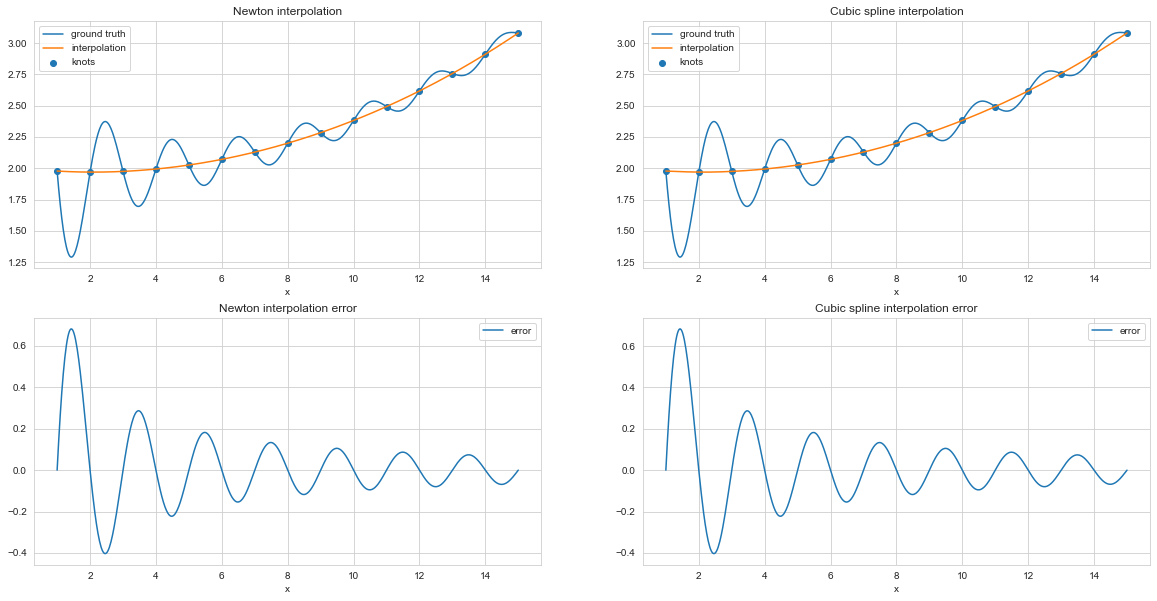

In [7]:
nKnotsDense =  600
h = (x1 - x0) / (nKnotsDense - 1)
xDense = np.arange(x0, x1 + h / 2, h)
newt_interp = NewtPoly.Compute(xDense)
spline_interp = CubeSpline.Compute(xDense)
fig,ax = plt.subplots(2,2, figsize=(20,10))

ax[0][0].plot(xDense, fTest(xDense), label='ground truth')
ax[0][0].scatter(xs, fs, label='knots')
ax[0][0].plot(xDense, newt_interp, label='interpolation')
ax[0][0].set_title('Newton interpolation')
ax[0][0].set(xlabel='x')

ax[0][1].plot(xDense, fTest(xDense), label='ground truth')
ax[0][1].scatter(xs, fs, label='knots')
ax[0][1].plot(xDense, spline_interp, label='interpolation')
ax[0][1].set_title('Cubic spline interpolation')
ax[0][1].set(xlabel='x')

ax[1][0].plot(xDense, newt_interp - fTest(xDense), label='error')
ax[1][0].set_title('Newton interpolation error')
ax[1][0].set(xlabel='x')

ax[1][1].plot(xDense, spline_interp - fTest(xDense), label='error')
ax[1][1].set_title('Cubic spline interpolation error')
ax[1][1].set(xlabel='x')

for i in range(2):
    for j in range(2):
        ax[i][j].legend()
plt.show()

*Оба метода выдают похожие результаты.*

*Interpolation on function with noise on 15 knots:*

Sigma = 1


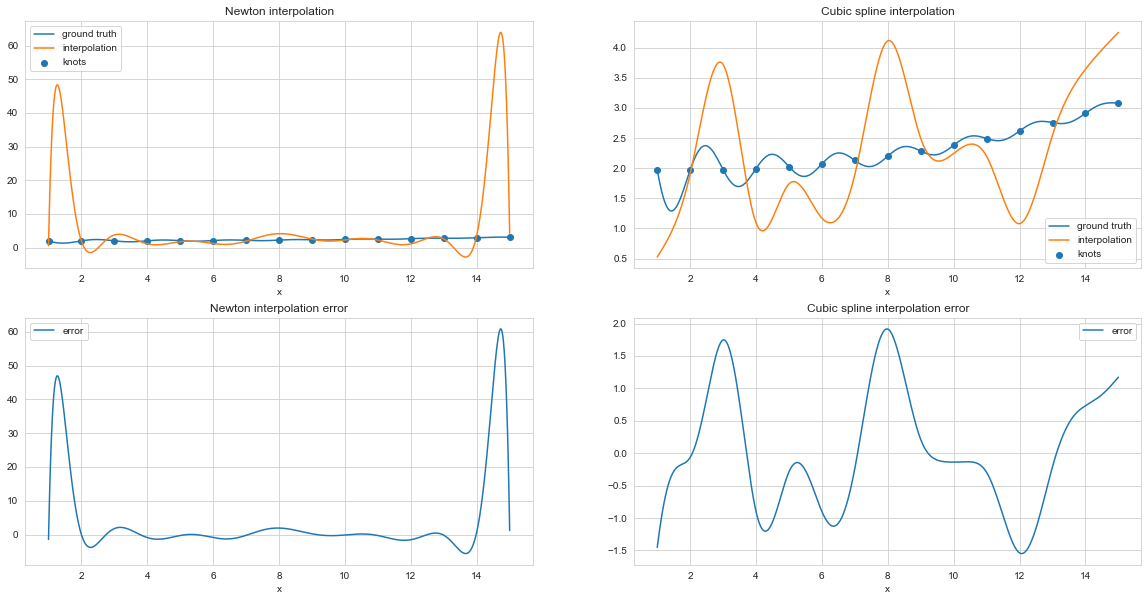

Sigma = 0.1


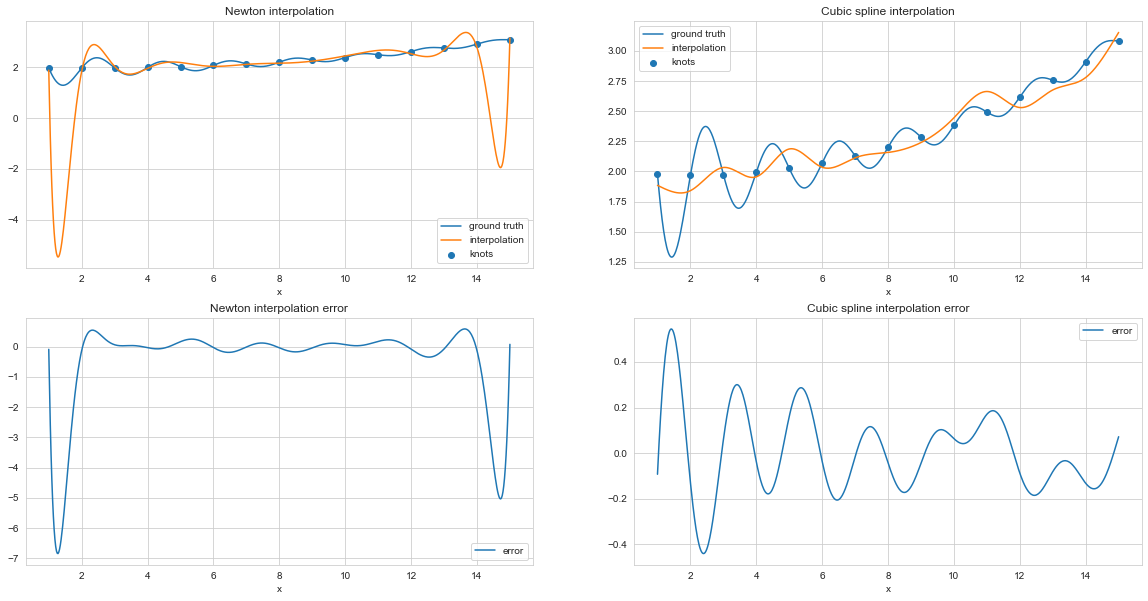

Sigma = 2


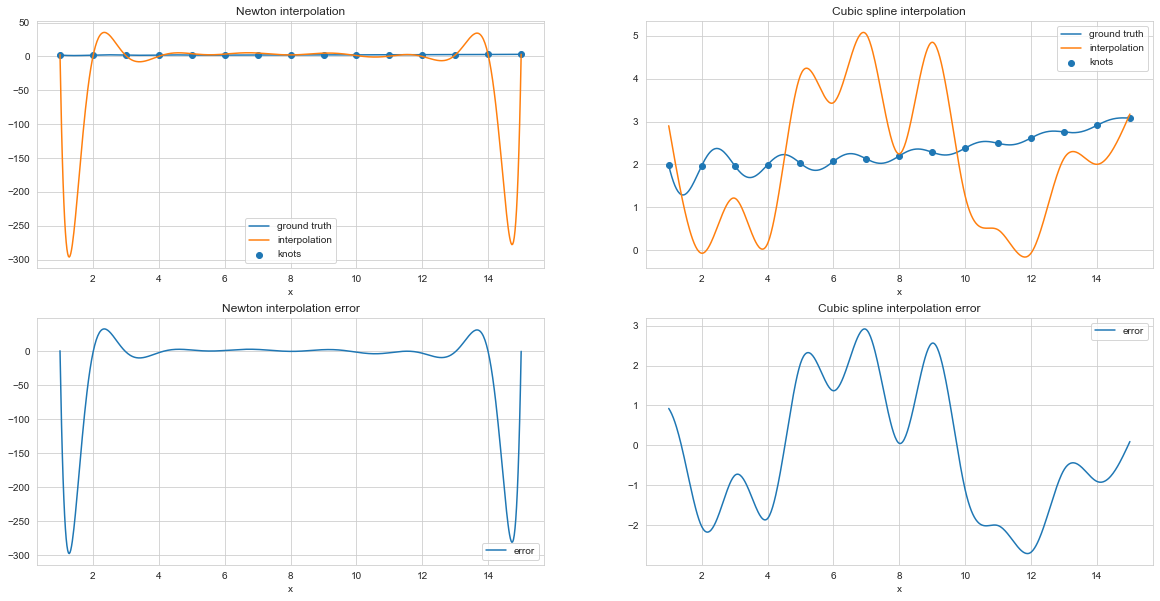

In [8]:
sigmas = [1, 0.1, 2]
for sigma in sigmas:
    print('Sigma =', sigma)
    noise = np.random.normal(0, sigma, len(fs))
    fs_noise = fs + noise
    NewtPoly_ = NewtonPolyInterpolator(xs, fs_noise)
    CubeSpline_ = CubicSplineInterpolator(xs, fs_noise)
    
    newt_interp_ = NewtPoly_.Compute(xDense)
    spline_interp_ = CubeSpline_.Compute(xDense)
    
    fig,ax = plt.subplots(2,2, figsize=(20,10))

    ax[0][0].plot(xDense, fTest(xDense), label='ground truth')
    ax[0][0].scatter(xs, fs, label='knots')
    ax[0][0].plot(xDense, newt_interp_, label='interpolation')
    ax[0][0].set_title('Newton interpolation')
    ax[0][0].set(xlabel='x')

    ax[0][1].plot(xDense, fTest(xDense), label='ground truth')
    ax[0][1].scatter(xs, fs, label='knots')
    ax[0][1].plot(xDense, spline_interp_, label='interpolation')
    ax[0][1].set_title('Cubic spline interpolation')
    ax[0][1].set(xlabel='x')

    ax[1][0].plot(xDense, newt_interp_ - fTest(xDense), label='error')
    ax[1][0].set_title('Newton interpolation error')
    ax[1][0].set(xlabel='x')

    ax[1][1].plot(xDense, spline_interp_ - fTest(xDense), label='error')
    ax[1][1].set_title('Cubic spline interpolation error')
    ax[1][1].set(xlabel='x')

    for i in range(2):
        for j in range(2):
            ax[i][j].legend()
    plt.show()    

*При $\sigma = 1$ многочлен Ньютона достаточно хорошо интерполирует часть функции посередине, однако видны большие ошибки на крайних значениях, из-за чего разброс значений ошибок у этого метода примерно от 0 до 60. Видно, что кубический сплайн намного лучше приближает функцию (разброс ошибок не более 2 по модулю). Аналогичную ситуацию можно заметить и при других значениях $\sigma$, при этом наблюдается уменьшение ошибки интерполяции с уменьшением значения $\sigma$ (при меньших $\sigma$ меньше значения шума, т.е. значения ближе к истинным значениях функций; при $\sigma = 0.1$ разброс ошибки для кубического сплайна не более 0.5 (по модулю), при $\sigma = 2$ - до 3).*

## Оценка констант Лебега

Константа Лебега -- это число, определяющее усточивость интерполяции по отношению к шумам в значениях функции $f(x)$; её можно определить как
$$
L := \sup_{t \in [a,b]} \sum_{j=0}^{K-1} \vert \phi_j(t) \vert,
$$
где $\phi_j$ -- базис интерполяции, зависящий как от метода (тригонометрический/многочлены/сплайны), так и от сетки (коэффициенты интерполяции, очевидно, зависят от неё).

Если не оговорено иного, то рассматривается равномерная сетка на $[-1,1]$. Для интерполяционного многочлена и тригонометрической интерполяции можно получить аналитически оценки на константу Лебега. В семинаре мы оценивали константу Лебега более грубо, давайте попробуем действовать аккуратнее.

### Задание 2 (15 баллов)

Докажите, что если $N \geq 2$, то константа Лебега для интерполяционного многочлена ограничена снизу как 
$$
L_N \geq K \frac{2^N}{N^{3/2}}
$$
с константой $K$, не зависящей от $N$.

### Задание 3 (15 баллов)

Докажите, что если $N \geq 2$, то константа Лебега для интерполяционного многочлена ограничена сверху как $L_N \leq K_0 2^N$ с константой $K_0$, не зависящей от $N$.

Подсказка к 2 и 3: докажите и используйте
$$
\prod_{j=0, ~j \neq i}^{n-1} \vert i-j\vert = i!(n-1-i)! \quad (1)
$$
и
$$
\prod_{j=0}^{n-1} (j+1/2) \geq \frac{(n-1)!}{2 \sqrt{n-1}} \quad (2)
$$
для $n \geq 2$.

#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

Докажем по индукции (1) и (2) для $n \geq 2$.

1) Возьмём для удобства $i = 0$ (при других значениях i док-во аналогично).

База: $n=2$:
(1) = $|0-1| = 1 = 0!(1-0)!$ - выполнено

Шаг: пусть выполнено для $n$, докажем для $n+1$:

$$\prod_{j=0, ~j \neq i}^{n + 1-1} \vert i-j\vert = \underbrace{\prod_{j=0, ~j \neq i}^{n-1} \vert i-j\vert}_{i!(n-1-i)!} \cdot |i - n| = i!(n-1-i)!(n-i) = i!(n-i)!$$ - ч.т.д.

2) База: $n=2$:

(2) = $(0+\frac{1}{2})(1 + \frac{1}{2}) = \frac{3}{4} \geqslant \frac{(2-1)!}{2\sqrt{2-1}} = \frac{1}{2}$ - выполнено

Шаг: пусть выполнено для $n$, докажем для $n+1$:

$$\prod_{j=0}^{n+1-1} (j+1/2) = \underbrace{\prod_{j=0}^{n-1} (j+1/2)}_{\geqslant \frac{(n-1)!}{2 \sqrt{n-1}}}\cdot (n + 1/2) \geqslant (n + 1/2) \cdot \frac{(n-1)!}{2 \sqrt{n-1}} \geqslant \frac{n!}{2 \sqrt{n-1}} \geqslant \frac{n!}{2 \sqrt{n}}$$ - ч.т.д.

Поскольку константа Лебега не зависит от длины отрезка, будем рассматривать следующую сетку значений: $\{x_i = i+1\}_{i=0}^{N-1}$

**Решение задания 2:**
$$L_N = \max\limits_{x \in [0, N-1]}\sum\limits_{i=0}^{N-1}\prod\limits_{j=0, j \neq i}^{N-1}\bigg|\frac{x-x_j}{x_i-x_j}\bigg| = \max\limits_{x \in [0, N-1]}\sum\limits_{i=0}^{N-1}\prod\limits_{j=0, j \neq i}^{N-1}\bigg|\frac{x-(j + 1)}{i-j}\bigg| = [(1)] = \max\limits_{x \in [0, N-1]}\sum\limits_{i=0}^{N-1}\frac{1}{i!(N-1-i)!}\prod\limits_{j=0, j \neq i}^{N-1}|x-(j+1)|$$

Используя то, что $\max\limits_{x \in [0,N-1]}|f(x)| \geqslant |f(1/2)|$, получим:
$$L_N \geqslant \sum\limits_{i=0}^{N-1}\frac{1}{i!(N-1-i)!}\prod\limits_{j=0, j \neq i}^{N-1}|-1/2-j|$$
Рассмотрим $\prod\limits_{j=0, j \neq i}^{N-1}|-1/2-j|$:

$$\prod\limits_{j=0, j \neq i}^{N-1}|-1/2-j| = \frac{1}{|1/2+i|}\prod\limits_{j=0}^{N-1}|1/2+j| = \geqslant [(2)] \geqslant \frac{1}{2|1/2 + i|}\frac{(N-1)!}{\sqrt{N-1}} \geqslant \frac{1}{2(N + 1/2)}\frac{(N-1)!}{\sqrt{N-1}}$$

Тогда получаем:
$$L_N \geqslant \frac{1}{2(N+1/2)\sqrt{N-1}}\sum\limits_{i=0}^{N-1}\frac{(N-1)!}{i!(N-1-i)!} = \frac{1}{2(N+1/2)\sqrt{N-1}}\underbrace{\sum\limits_{i=0}^{N-1}\binom{N-1}{i}}_{= 2^{N-1}} \geqslant \frac{2^{N-1}}{2N^{3/2}} = K\frac{2^N}{N^{3/2}}, \, K = 1/4$$

**Решение задания 3:**
Аналогично предыдущему решению, используя (1), получаем:
$$L_N = \max\limits_{x \in [0, N-1]}\sum\limits_{i=0}^{N-1}\frac{1}{i!(N-1-i)!}\prod\limits_{j=0, j \neq i}^{N-1}|x-(j+1)|$$
Рассмотрим $\prod\limits_{j=0, j \neq i}^{N-1}|x-(j+1)|$:

Обозначим произвольную точку $x = a + d$, где $a$ - целое, для $x \in [1,N-2] \, |d| \leqslant \frac{1}{2}; \, x = N-1: d \in [-1/2,0]; \, x = 0: d \in[0,1/2]$ (Т.е. каждая точка записывается как сумма ближайшего целого числа и остатка меньшего или равного 1/2).

Тогда получаем:
$$\prod\limits_{j=0, j \neq i}^{N-1}|x-(j+1)| = \frac{1}{|x-(i+1)|}\prod\limits_{j=0}^{N-1}|x-(j+1)| = \frac{1}{|x-(i+1)|}|\underbrace{(d+(a-1))(d+(a-2))...(d+(a-(a-1)))}_{\text{* - расстояние от $x$ до точек его левее}}d\underbrace{(1-d)(2-d)...(N-a-d)}_{\text{** - расстояние от $x$ до точек его правее}}|$$

Рассмотрим \* и \*\*:

При $0<d<1/2$:
$$(d+a-1)(d+a-2)...(d+1) \leqslant a! \quad \quad (1-d)(2-d)...(N-a-d) \leqslant (N - a)!$$
При $-1/2<d<0$:
$$(d+a-1)(d+a-2)...(d+1) \leqslant (a-1)! \quad \quad (1-d)(2-d)...(N-a-d) \leqslant (N - (a-1))!$$

В обоих случаях получаем:
$$a!(N-a)! \leqslant (a + N - a - 1)! \quad \quad (a-1)!(N-(a-1))! \leqslant (a-1+N-(a-1)-1)! \iff (*)\cdot (**) \leqslant (N-1)!$$

Тогда:
$$\frac{1}{|x-(i+1)|}\prod\limits_{j=0}^{N-1}|x-(j+1)| = \frac{|d|}{|x-(i+1)|}|(d+(a-1))(d+(a-2))...(d+(a-(a-1)))(1-d)(2-d)...(N-a-d)| \leqslant \bigg[\frac{|d|}{|x-(i+1)|} \leqslant 1\bigg] \leqslant (N-1)!$$

Вернёмся к исходной задаче:
$$L_N = \max\limits_{x \in [0, N-1]}\sum\limits_{i=0}^{N-1}\frac{1}{i!(N-1-i)!}\prod\limits_{j=0, j \neq i}^{N-1}|x-(j+1)| \leqslant \sum\limits_{i=0}^{N-1}\frac{(N-1)!}{i!(N-1-i)!} = \sum\limits_{i=0}^{N-1}\binom{N-1}{i} = 2^{N-1} = K_0\cdot 2^N, \, K_0 = 1/2$$

Оценим константы Лебега для многочлена Ньютона и кубического сплайна эмпирически для равномерной сетки и Чебышёвской сетки (построенной из корней многочлена Чебышёва). Пусть нас интересует отрезок $[0,1]$ и на нём берётся $N$ узлов для интерполяции. Можете приблизительно вычислять максимум в выражении для константы Лебега как удобно, не забудьте выписать, что является базисными функциями для каждого из методов.

### Задание 5 (15 баллов)

Нарисуйте зависимость $L_N$ от $N$ для двух алгоритмов интерполяции (рассмотрите $N \in [5,1000]$ ) для равномерной и чебышёвской сеток. Опишите увиденный результат, сравните его с теоретическими оценками. Если графики нечитаемы, попробуйте их нарисовать в логарифмических осях.

Базисные функции:
- интерполяции многочленами Ньютона:
$$\phi_{j}(x) = \prod _{{i=0}}^{{j-1}}(x-x_{i})$$
- интерполяции кубическими сплайнами:
$$\phi_{j}(x) = S_j(x)I\{x \in I_j\}, \quad S_n - \text{ сплайн}$$

In [9]:
Ns = np.array(range(5,1001,5))
L_newt = []
for N in Ns:
    xs = np.linspace(0, 1, N)
    cheb_xs = np.array(sorted([1/2 + np.cos((2*k-1)/(2*N)*np.pi)/2 for k in range(1,N+1)]))
    x_arr = np.linspace(min(cheb_xs), max(cheb_xs), 500)
    vals = abs(np.cumprod(x_arr[:,None] - xs[None,:], axis=-1)[:,:-1])    # abs. values of Newton basis functions for each point in x_arr
    cheb_vals = abs(np.cumprod(x_arr[:,None] - cheb_xs[None,:], axis=-1)[:,:-1])    # abs. values of Newton basis functions for each point in x_arr
    L_newt.append((max(np.sum(vals, axis=1)), max(np.sum(cheb_vals, axis=1))))

In [10]:
L_spline = []
for N in Ns:
    xs = np.linspace(0.001, 1, N)
    cheb_xs = np.array(sorted([1/2 + np.cos((2*k-1)/(2*N)*np.pi)/2 for k in range(1,N+1)]))
    x_arr = np.linspace(min(cheb_xs), max(cheb_xs), 500)
    
    spline = CubicSplineInterpolator(xs, fTest(xs))
    comp = abs(spline.Compute(x_arr))    # abs. value of spline function
    intervals_idx = np.searchsorted(xs, x_arr, side='right') - 1
    intervals_idx[intervals_idx == (N-1)] -= 1    # n + 1 to n
    vals = np.zeros((x_arr.shape[0], N - 1),dtype=float)
    for i in range(vals.shape[0]):
        vals[i][intervals_idx[i]] = comp[i]
    
    cheb_spline = CubicSplineInterpolator(cheb_xs, fTest(cheb_xs))
    cheb_comp = abs(cheb_spline.Compute(x_arr))    # abs. value of spline function
    intervals_idx = np.searchsorted(cheb_xs, x_arr, side='right') - 1
    intervals_idx[intervals_idx == (N - 1)] -= 1    # n + 1 to n
    cheb_vals = np.zeros((x_arr.shape[0], N - 1),dtype=float)
    for i in range(cheb_vals.shape[0]):
        cheb_vals[i][intervals_idx[i]] = cheb_comp[i]
    L_spline.append((max(np.sum(vals, axis=1)), max(np.sum(cheb_vals, axis=1))))

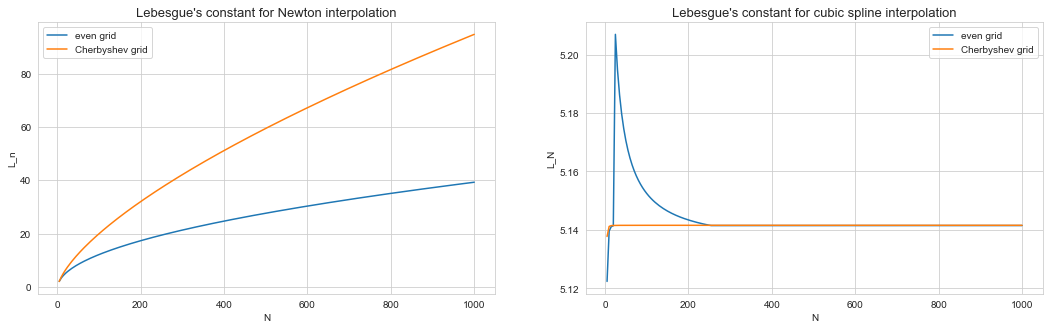

In [13]:
fig, axs = plt.subplots(1,2,figsize=(18,5))
axs[0].plot(Ns, [x[0] for x in L_newt], label='even grid')
axs[0].plot(Ns, [x[1] for x in L_newt], label='Cherbyshev grid')
axs[0].set_title('Lebesgue\'s constant for Newton interpolation', fontsize=13)
axs[0].set(xlabel='N', ylabel='L_n')
axs[0].legend()

axs[1].plot(Ns, [x[0] for x in L_spline], label='even grid')
axs[1].plot(Ns, [x[1] for x in L_spline], label='Cherbyshev grid')
axs[1].set_title('Lebesgue\'s constant for cubic spline interpolation', fontsize=13)
axs[1].set(xlabel='N', ylabel='L_N')
axs[1].legend()

plt.show()

*Можем увидеть, что в методе Ньютона графики для обоих видов сетки похожи по структуре, тогда как для интерполяции со сплайном результаты для разных сеток различаются. В методе Ньютона константа Лебега возрастает с увеличением количества узлов, а в кубическом сплайне константа Лебега выходит на одно значение, более маленькое относительно метода Ньютона.*

### Задание 6 (5 баллов)

Нарисуйте графики интерполяционных функций на равномерной и чебышёвской сетке в сравнении с тестовой функцией приведённой ниже. Рассмотрите число узлов $N=5,15,30$ и посмотрите, как будет меняться качество интерполяции. Сделайте вывод на основе всех экспериментов, какой метод более надёжный для большего числа узлов и как оба метода реагируют на шум в узлах.

In [14]:
def fTest(x):
    #maps R -> R
    #input x [batch]
    #output [batch]
    
    return np.exp(-0.1*x) + 1/x * np.sin(1*np.pi * x)+ np.exp(0.07*x)

N = 5


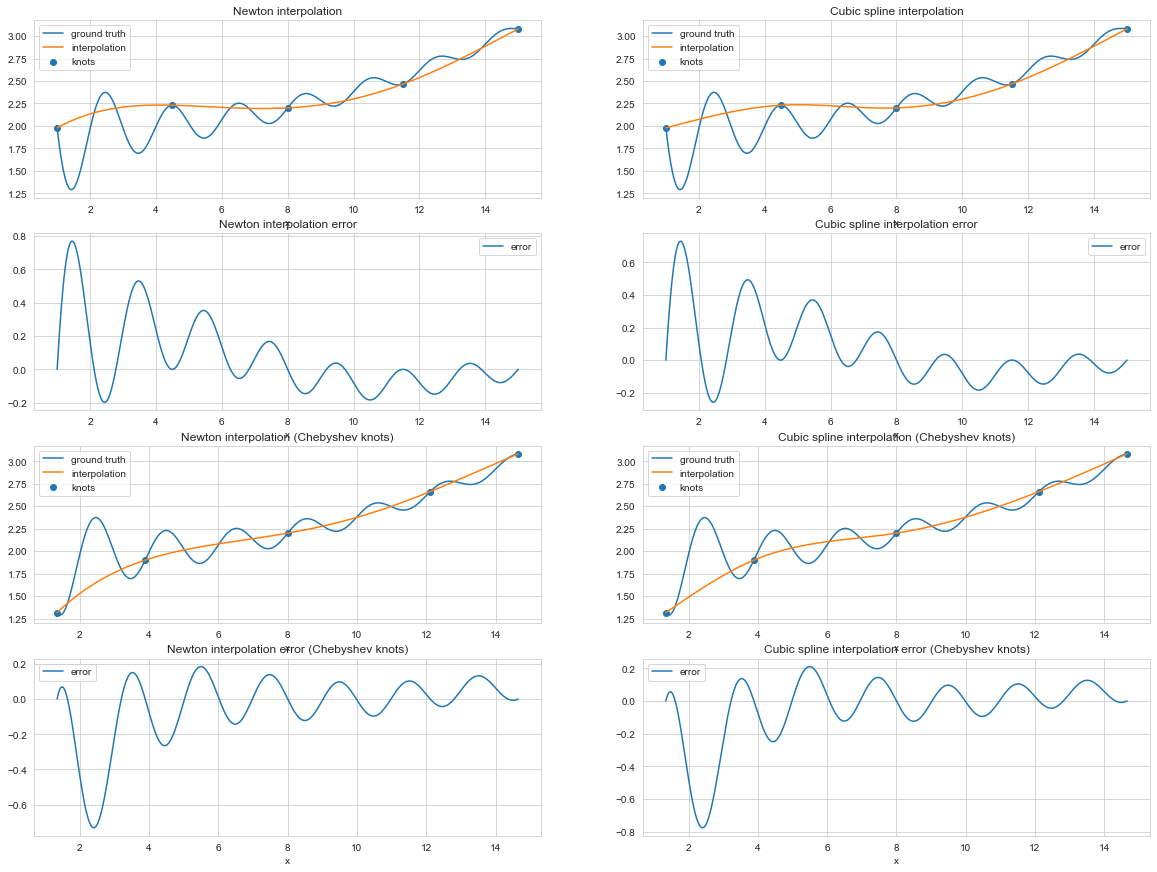

N = 15


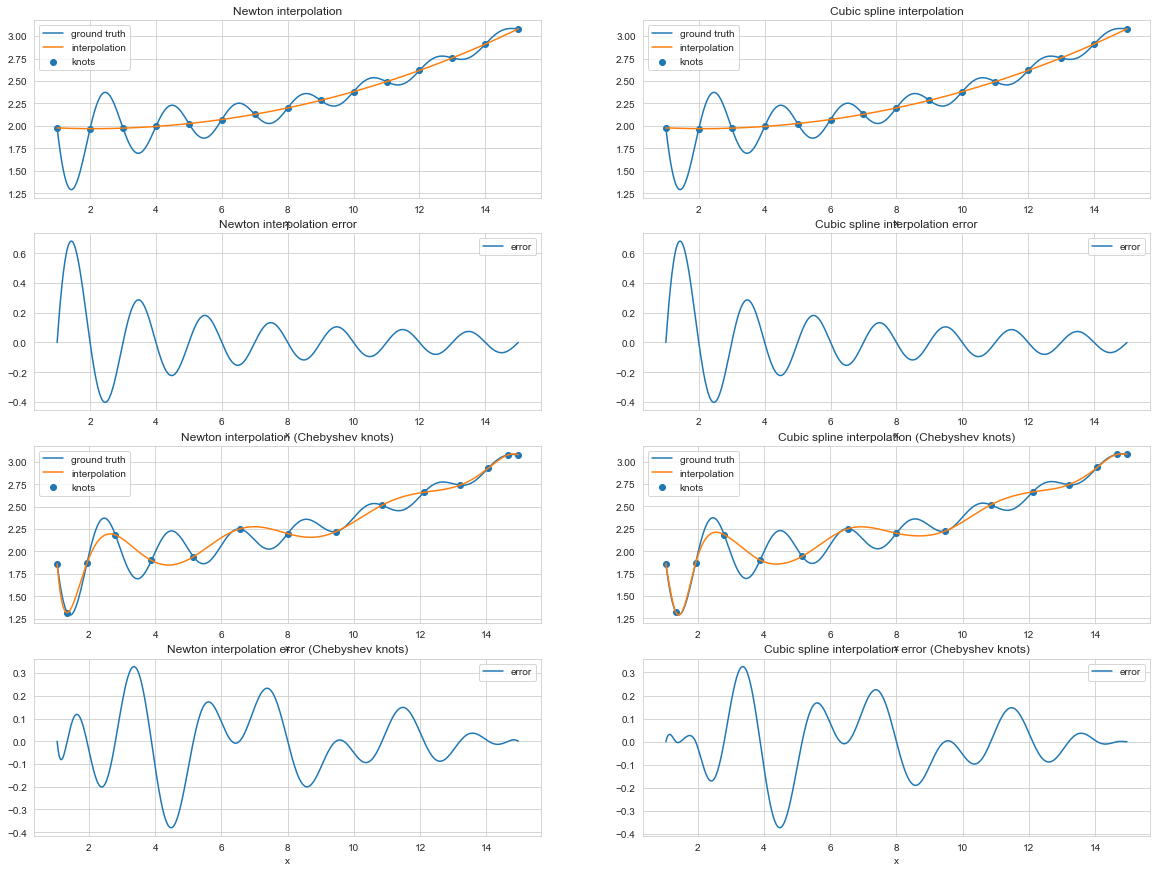

N = 30


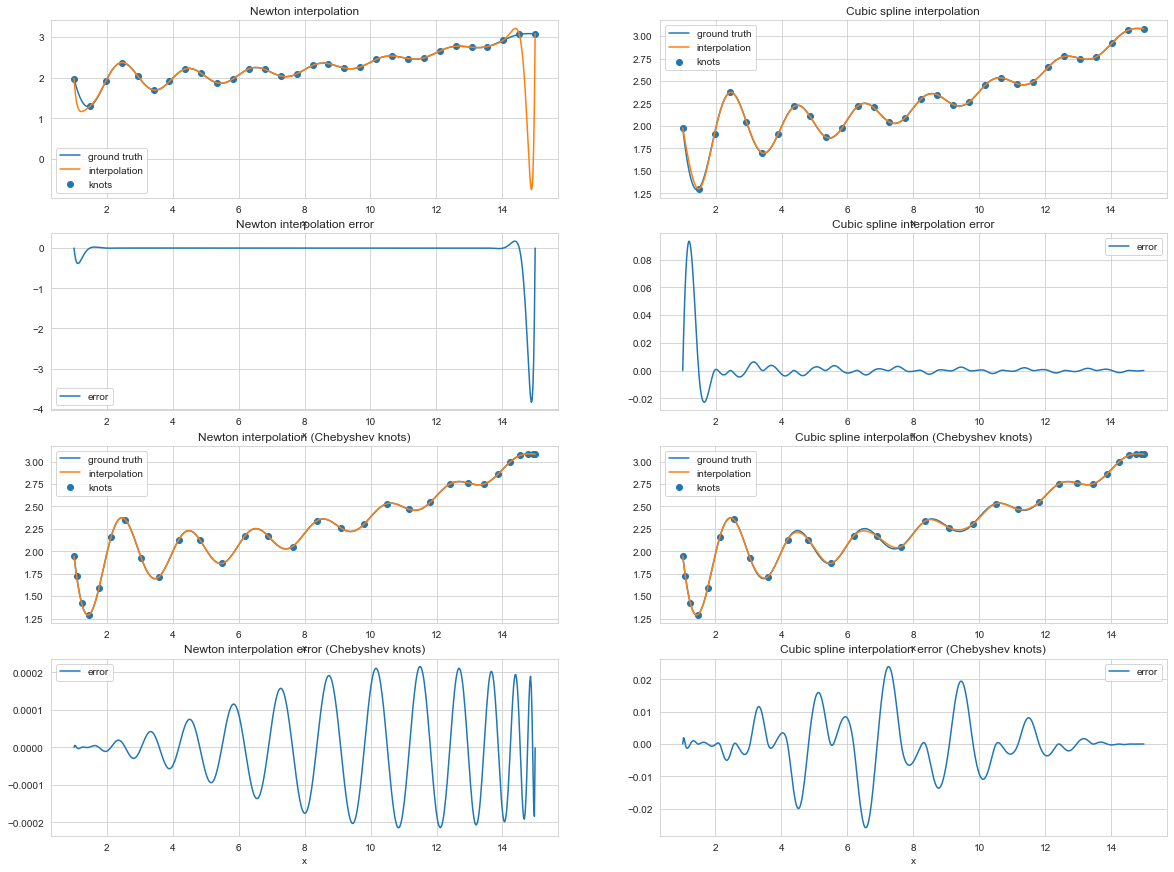

In [15]:
n_values = [5, 15, 30]
for n in n_values:
    print('N =', n)
    x0=1
    x1=15
    h = (x1 - x0) / (n - 1)
    xs = np.arange(x0, x1 + h / 2, h)
    cheb_xs = np.array(sorted([(x0+x1)/2 + (x1-x0)*np.cos((2*k-1)/(2*n)*np.pi)/2 for k in range(1,n+1)]))
    x0_, x1_ = min(cheb_xs), max(cheb_xs)
    h_ = (x1_ - x0_) / (nKnotsDense - 1)
    cheb_xDense = np.arange(x0_, x1_ + h_ / 2, h_)

    fs = fTest(xs)
    cheb_fs = fTest(cheb_xs)
    
    NewtPoly_ = NewtonPolyInterpolator(xs, fs)
    CubeSpline_ = CubicSplineInterpolator(xs, fs)
    cheb_NewtPoly = NewtonPolyInterpolator(cheb_xs, cheb_fs)
    cheb_CubeSpline = CubicSplineInterpolator(cheb_xs, cheb_fs)
    
    newt_interp_ = NewtPoly_.Compute(xDense)
    spline_interp_ = CubeSpline_.Compute(xDense)
    cheb_newt = cheb_NewtPoly.Compute(cheb_xDense)
    cheb_spline = cheb_CubeSpline.Compute(cheb_xDense)
    
    fig,ax = plt.subplots(4,2, figsize=(20,15))

    ax[0][0].plot(xDense, fTest(xDense), label='ground truth')
    ax[0][0].scatter(xs, fs, label='knots')
    ax[0][0].plot(xDense, newt_interp_, label='interpolation')
    ax[0][0].set_title('Newton interpolation')
    ax[0][0].set(xlabel='x')

    ax[0][1].plot(xDense, fTest(xDense), label='ground truth')
    ax[0][1].scatter(xs, fs, label='knots')
    ax[0][1].plot(xDense, spline_interp_, label='interpolation')
    ax[0][1].set_title('Cubic spline interpolation')
    ax[0][1].set(xlabel='x')

    ax[1][0].plot(xDense, newt_interp_ - fTest(xDense), label='error')
    ax[1][0].set_title('Newton interpolation error')
    ax[1][0].set(xlabel='x')

    ax[1][1].plot(xDense, spline_interp_ - fTest(xDense), label='error')
    ax[1][1].set_title('Cubic spline interpolation error')
    ax[1][1].set(xlabel='x')

    ax[2][0].plot(cheb_xDense, fTest(cheb_xDense), label='ground truth')
    ax[2][0].scatter(cheb_xs, cheb_fs, label='knots')
    ax[2][0].plot(cheb_xDense, cheb_newt, label='interpolation')
    ax[2][0].set_title('Newton interpolation (Chebyshev knots)')
    ax[2][0].set(xlabel='x')

    ax[2][1].plot(cheb_xDense, fTest(cheb_xDense), label='ground truth')
    ax[2][1].scatter(cheb_xs, cheb_fs, label='knots')
    ax[2][1].plot(cheb_xDense, cheb_spline, label='interpolation')
    ax[2][1].set_title('Cubic spline interpolation (Chebyshev knots)')
    ax[2][1].set(xlabel='x')

    ax[3][0].plot(cheb_xDense, cheb_newt - fTest(cheb_xDense), label='error')
    ax[3][0].set_title('Newton interpolation error (Chebyshev knots)')
    ax[3][0].set(xlabel='x')

    ax[3][1].plot(cheb_xDense, cheb_spline - fTest(cheb_xDense), label='error')
    ax[3][1].set_title('Cubic spline interpolation error (Chebyshev knots)')
    ax[3][1].set(xlabel='x')
    
    for i in range(4):
        for j in range(2):
            ax[i][j].legend()
    plt.show()    

*Functions with noise:*

N = 5


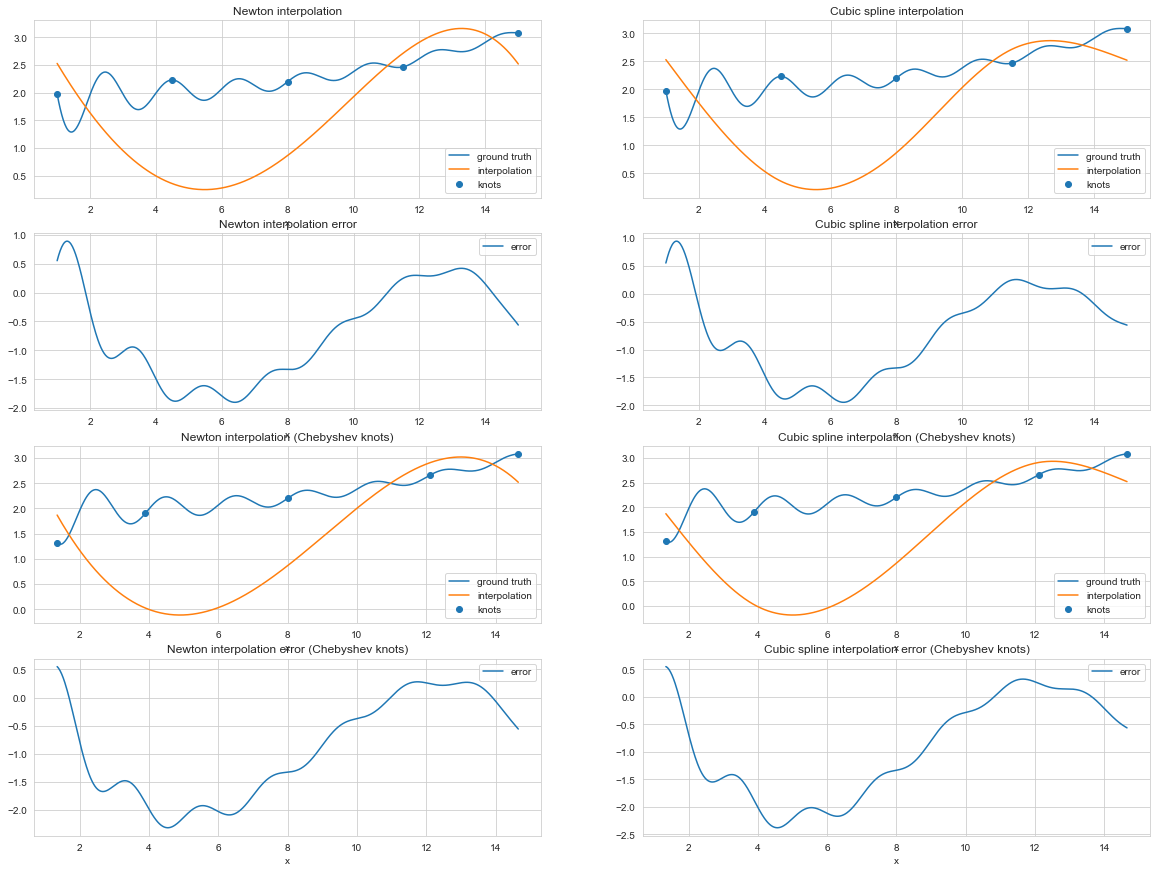

N = 15


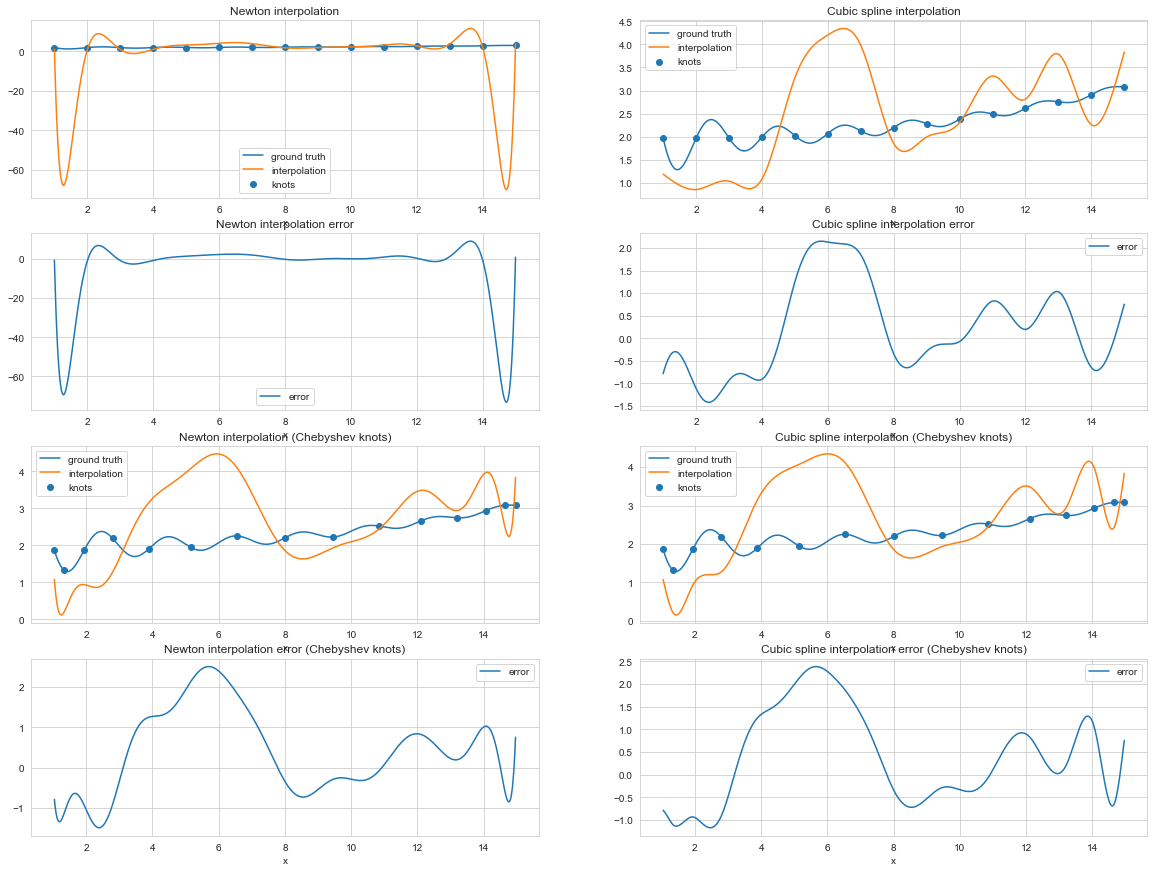

N = 30


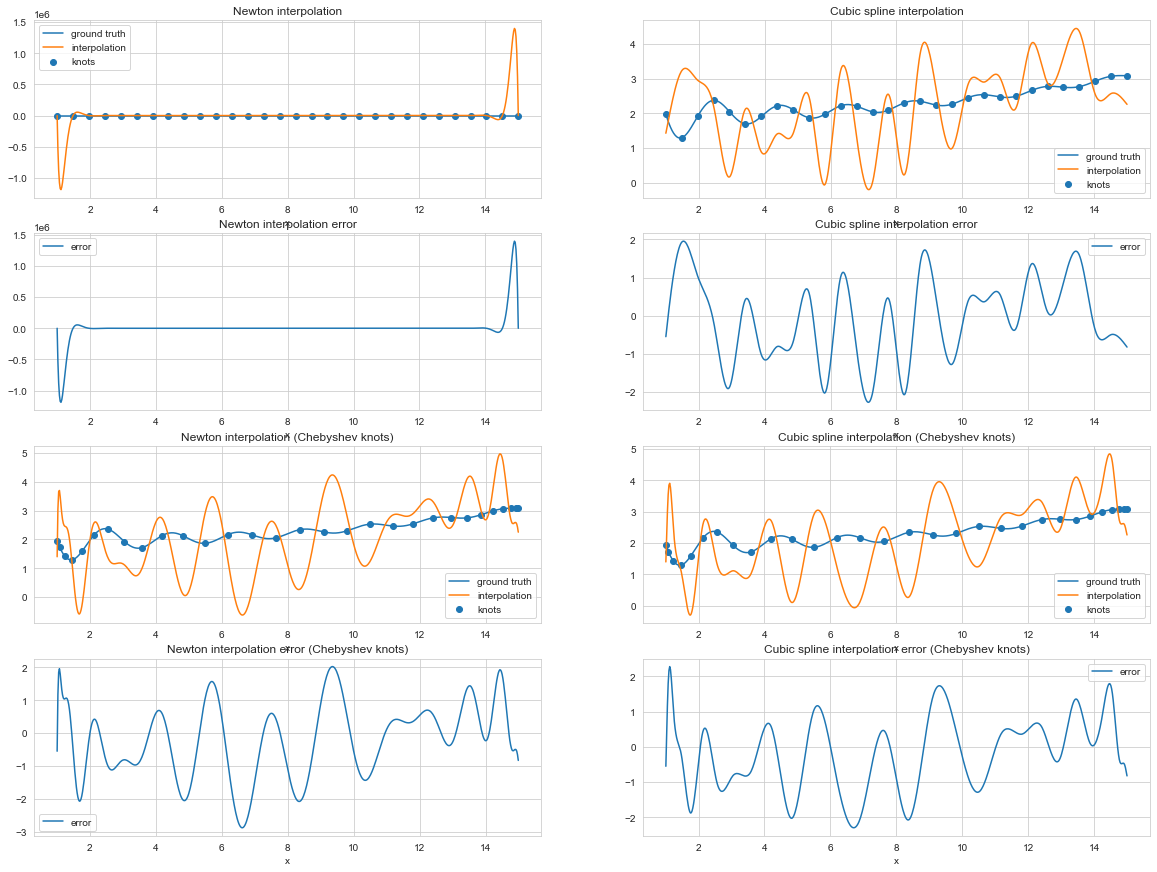

In [16]:
n_values = [5, 15, 30]
for n in n_values:
    print('N =', n)
    x0=1
    x1=15
    h = (x1 - x0) / (n - 1)
    xs = np.arange(x0, x1 + h / 2, h)
    cheb_xs = np.array(sorted([(x0+x1)/2 + (x1-x0)*np.cos((2*k-1)/(2*n)*np.pi)/2 for k in range(1,n+1)]))
    x0_, x1_ = min(cheb_xs), max(cheb_xs)
    h_ = (x1_ - x0_) / (nKnotsDense - 1)
    cheb_xDense = np.arange(x0_, x1_ + h_ / 2, h_)

    fs = fTest(xs)
    noise = np.random.normal(0, 1, len(fs))
    fs_noise = fs + noise
    cheb_fs = fTest(cheb_xs)
    cheb_fs_noise = cheb_fs + noise
    
    NewtPoly_ = NewtonPolyInterpolator(xs, fs_noise)
    CubeSpline_ = CubicSplineInterpolator(xs, fs_noise)
    cheb_NewtPoly = NewtonPolyInterpolator(cheb_xs, cheb_fs_noise)
    cheb_CubeSpline = CubicSplineInterpolator(cheb_xs, cheb_fs_noise)
    
    newt_interp_ = NewtPoly_.Compute(xDense)
    spline_interp_ = CubeSpline_.Compute(xDense)
    cheb_newt = cheb_NewtPoly.Compute(cheb_xDense)
    cheb_spline = cheb_CubeSpline.Compute(cheb_xDense)
    
    fig,ax = plt.subplots(4,2, figsize=(20,15))

    ax[0][0].plot(xDense, fTest(xDense), label='ground truth')
    ax[0][0].scatter(xs, fs, label='knots')
    ax[0][0].plot(xDense, newt_interp_, label='interpolation')
    ax[0][0].set_title('Newton interpolation')
    ax[0][0].set(xlabel='x')

    ax[0][1].plot(xDense, fTest(xDense), label='ground truth')
    ax[0][1].scatter(xs, fs, label='knots')
    ax[0][1].plot(xDense, spline_interp_, label='interpolation')
    ax[0][1].set_title('Cubic spline interpolation')
    ax[0][1].set(xlabel='x')

    ax[1][0].plot(xDense, newt_interp_ - fTest(xDense), label='error')
    ax[1][0].set_title('Newton interpolation error')
    ax[1][0].set(xlabel='x')

    ax[1][1].plot(xDense, spline_interp_ - fTest(xDense), label='error')
    ax[1][1].set_title('Cubic spline interpolation error')
    ax[1][1].set(xlabel='x')

    ax[2][0].plot(cheb_xDense, fTest(cheb_xDense), label='ground truth')
    ax[2][0].scatter(cheb_xs, cheb_fs, label='knots')
    ax[2][0].plot(cheb_xDense, cheb_newt, label='interpolation')
    ax[2][0].set_title('Newton interpolation (Chebyshev knots)')
    ax[2][0].set(xlabel='x')

    ax[2][1].plot(cheb_xDense, fTest(cheb_xDense), label='ground truth')
    ax[2][1].scatter(cheb_xs, cheb_fs, label='knots')
    ax[2][1].plot(cheb_xDense, cheb_spline, label='interpolation')
    ax[2][1].set_title('Cubic spline interpolation (Chebyshev knots)')
    ax[2][1].set(xlabel='x')

    ax[3][0].plot(cheb_xDense, cheb_newt - fTest(cheb_xDense), label='error')
    ax[3][0].set_title('Newton interpolation error (Chebyshev knots)')
    ax[3][0].set(xlabel='x')

    ax[3][1].plot(cheb_xDense, cheb_spline - fTest(cheb_xDense), label='error')
    ax[3][1].set_title('Cubic spline interpolation error (Chebyshev knots)')
    ax[3][1].set(xlabel='x')
    
    for i in range(4):
        for j in range(2):
            ax[i][j].legend()
    plt.show()    

*По построенным графикам можем увидеть, что при небольших значениях N оба метода показывают похожие результаты (как при равномерной, так и при Чебышёвской сетке), однако с увеличением N наблюдаются различия между интерполяцией многочленом Ньютона и сплайном. Для равномерной сетки выходит, что многочлен Ньютона приближает функцию хуже, чем сплайн (большие ошибки на концах, сплайн ошибается максимум на 0.09), однако для чебышёвской сетки многочлен Ньютона наоборот выдаёт более качественную интерполяцию: ошибки тут совсем небольшие - до 0.0003, тогда как в сплайнах ошибки могут превышать 0.02. Таким образом, для данной сетки метод Ньютона более надёжный.*

*Отдельно стоит обратить внимание на работу методов при зашумлённых значениях функции: по графикам можно увидеть, что на равномерной сетке качество интерполяции многочленом Ньютона выходит хуже качества интерполяции кубическим сплайном (при всех рассмотренных N), тогда как при использовании Чебышёвской сетки графики (и качество интерполяции) для двух методов выходят очень похожими. При анализе константы Лебега для обоих методов можно было заметить, что его значение для кубических сплайнов выходит меньше, что показывает, что их использование в случае зашумлённой функции лучше.*